In [41]:
import squidpy as sq
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
import altair as alt

# Load in raw data from Space Ranger output

In [42]:
adata = sq.read.visium(path="../../data/spatial/raw/ctrl_p7/outs", counts_file="spatial_ACH003_raw_feature_bc_matrix.h5", library_id="ctrl_p7")
adata.var_names_make_unique()

/home/jupyter/heart/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jupyter/heart/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [43]:
adata

AnnData object with n_obs × n_vars = 4992 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [44]:
adata.obs

,in_tissue,array_row,array_col
AAACAACGAATAGTTC-1,0,0,16
AAACAAGTATCTCCCA-1,1,50,102
AAACAATCTACTAGCA-1,0,3,43
AAACACCAATAACTGC-1,0,59,19
AAACAGAGCGACTCCT-1,0,14,94
...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30
TTGTTTCCATACAACT-1,1,45,27
TTGTTTGTATTACACG-1,1,73,41


In [45]:
adata.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38
AC023491.2,ENSG00000278633,Gene Expression,GRCh38
AC007325.1,ENSG00000276017,Gene Expression,GRCh38
AC007325.4,ENSG00000278817,Gene Expression,GRCh38


# RNA QC metrics

In [46]:
adata.var['mt'] = adata.var_names.str.startswith("MT-")
adata.var['ribo'] = adata.var_names.str.startswith(("RPS", "MRP", "RPL"))
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", 'ribo'], inplace=True, log1p=True)

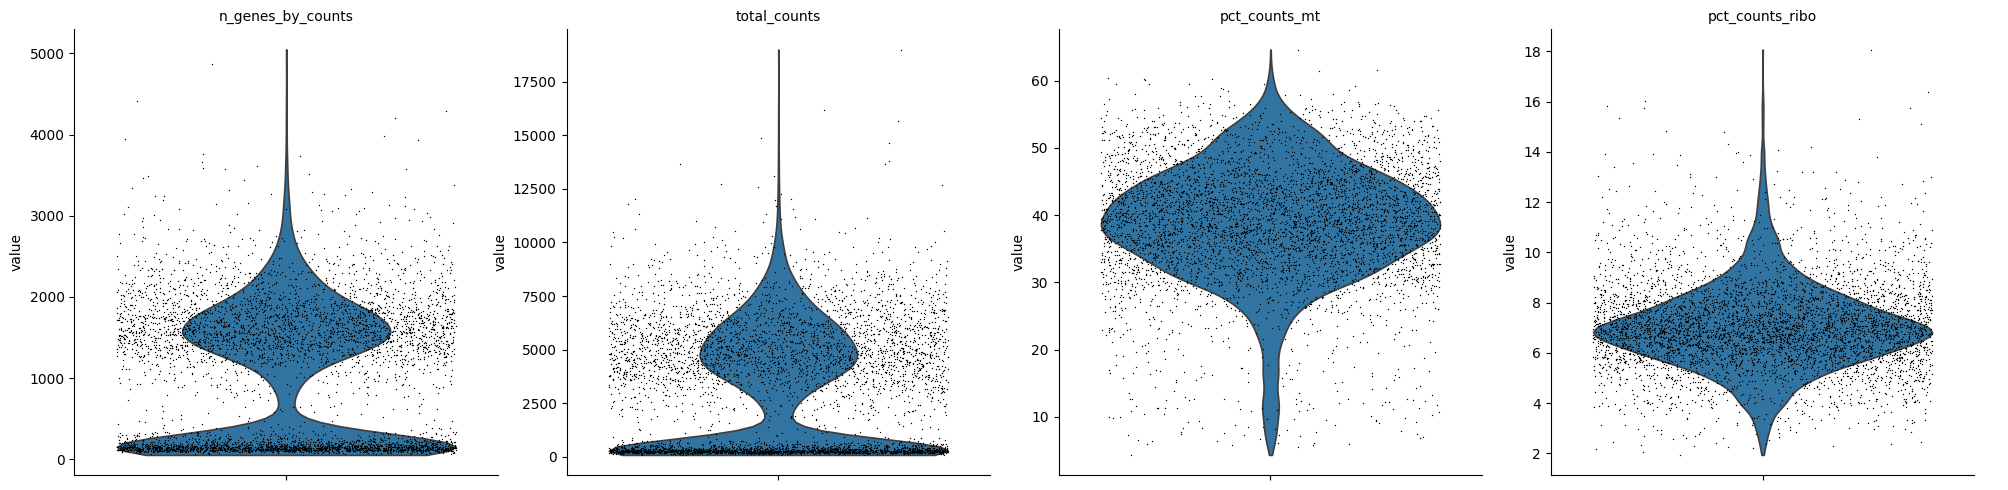

In [47]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.4, multi_panel=True)

In [48]:
adata

AnnData object with n_obs × n_vars = 4992 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

# Filter data

In [49]:
# remove mitochondrial and ribosomal genes
adata = adata[:, ~adata.var_names.str.startswith('MT-')].copy()
adata = adata[:, ~adata.var_names.str.startswith(("RPS", "MRP", "RPL"))].copy()

In [50]:
# filter out spots with < 300 genes and < 500 UMIs
sc.pp.filter_cells(adata, min_genes = 300)
sc.pp.filter_cells(adata, min_counts = 500)

In [51]:
adata

AnnData object with n_obs × n_vars = 2982 × 36404
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

# Data Normalization

In [52]:
adata.raw = adata

In [53]:
# Normalize to 10,000 total counts per spot
sc.pp.normalize_total(adata, target_sum=1e4)
# Log transform the data
sc.pp.log1p(adata)

In [54]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

# Manifold embedding and clustering based on transcriptional similarity

In [55]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters", flavor="igraph", directed=False, n_iterations=2
)

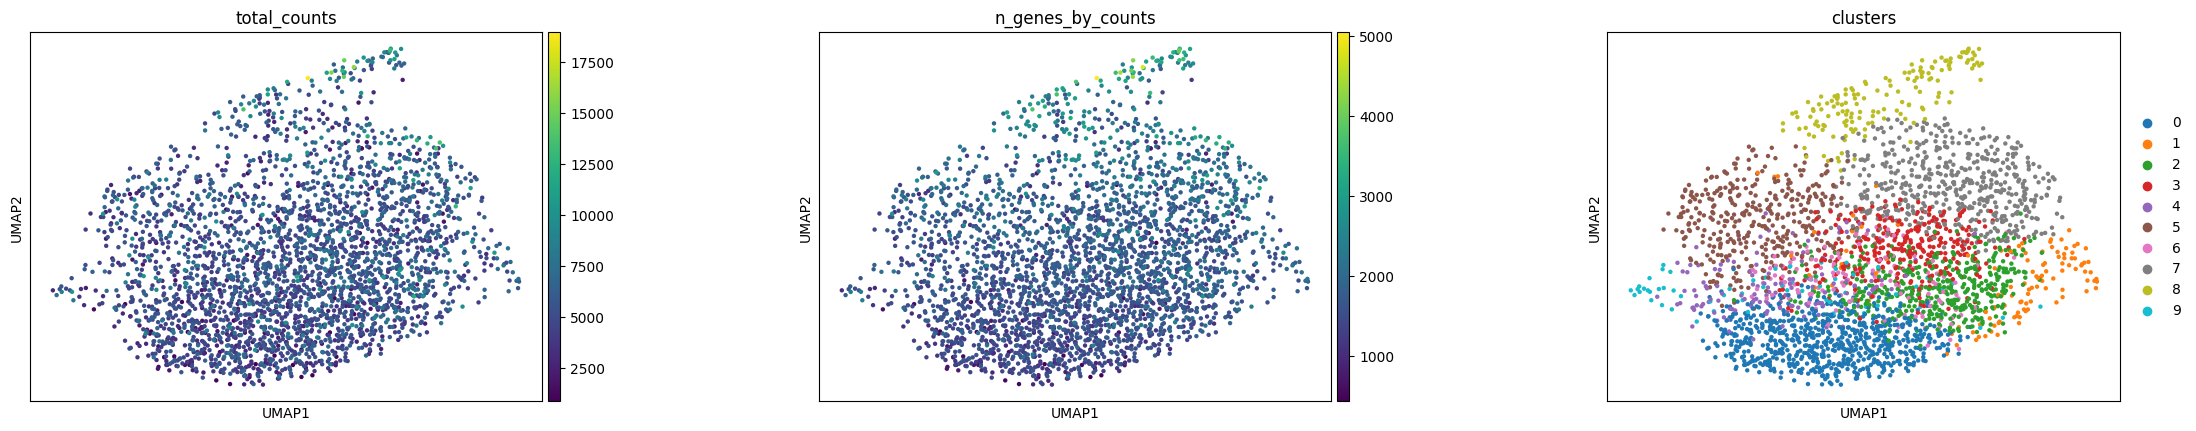

In [56]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

In [57]:
# Visualization of spatial coordinates

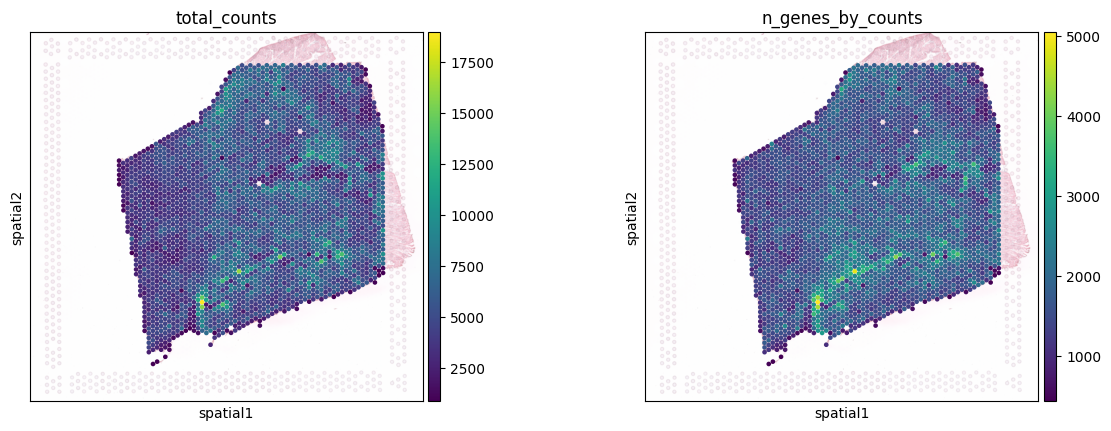

In [58]:
sq.pl.spatial_scatter(adata, color=["total_counts", "n_genes_by_counts"], img_alpha=0.4, size=1.5)

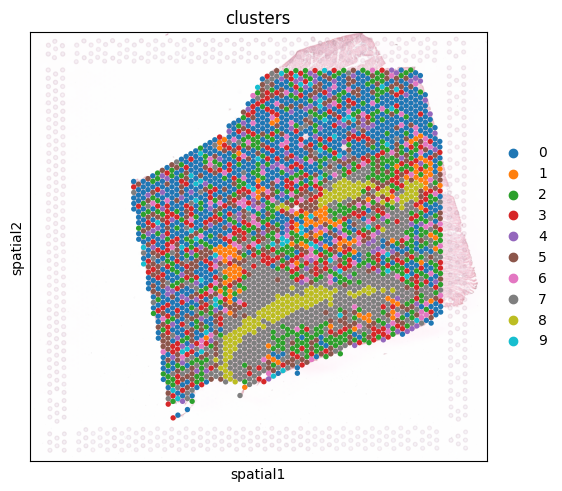

In [59]:
sq.pl.spatial_scatter(adata, color="clusters", img_alpha=0.4, size=1.5)

# Spatial statistics and graph analysis

## Neighborhood enrichment

Computing a neighborhood enrichment can help us identify spots clusters that share a common neighborhood structure across the tissue. 

In [60]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="clusters")

  0%|          | 0/1000 [00:00<?, ?/s]

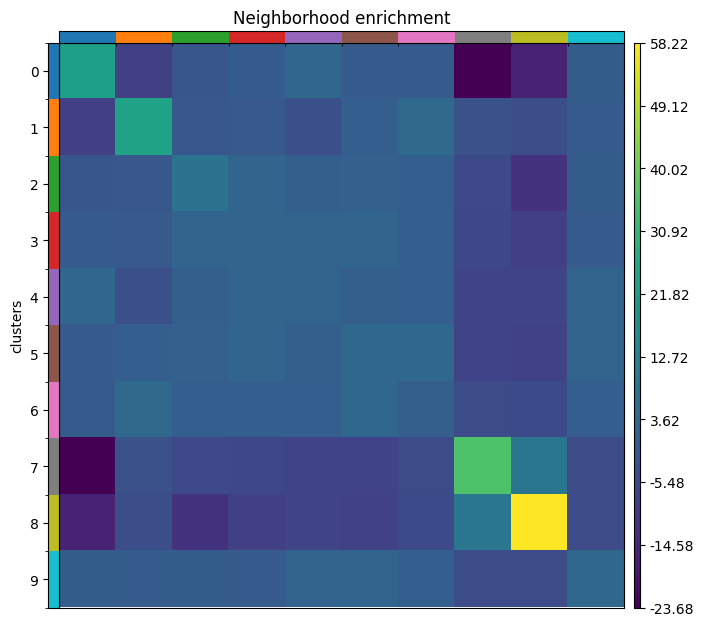

In [61]:
sq.pl.nhood_enrichment(adata, cluster_key="clusters")

## Co-occurrence across spatial dimensions

  0%|          | 0/1 [00:00<?, ?/s]

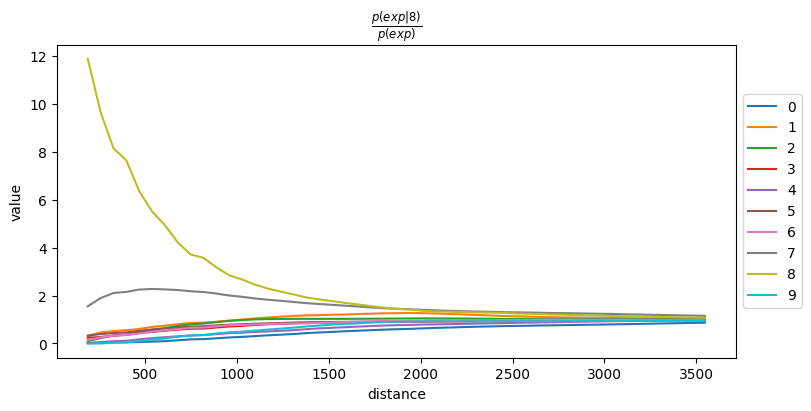

In [62]:
sq.gr.co_occurrence(adata, cluster_key="clusters")
sq.pl.co_occurrence(
    adata,
    cluster_key="clusters",
    clusters="8",
    figsize=(8, 4),
)

In [63]:
adata.var

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False,1.000000e-12,NaN,NaN
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False,1.000000e-12,NaN,NaN
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False,1.000000e-12,NaN,NaN
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,2,0.000401,0.000401,99.959936,2.0,1.098612,False,1.807210e-03,1.015150,-1.256509
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False,1.000000e-12,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False,1.000000e-12,NaN,NaN
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False,1.000000e-12,NaN,NaN
AC007325.1,ENSG00000276017,Gene Expression,GRCh38,False,False,0,0.000000,0.000000,100.000000,0.0,0.000000,False,1.000000e-12,NaN,NaN
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,False,False,211,0.045072,0.044086,95.773237,225.0,5.420535,False,2.271609e-01,1.449291,0.353662


## Ligand-receptor interaction analysis

In [64]:
sq.gr.ligrec(
    adata,
    n_perms=100,
    cluster_key="clusters",
)

  0%|          | 0/100 [00:00<?, ?permutation/s]

## Spatially variable genes with Moran’s I

In [77]:
genes = adata[:, adata.var.highly_variable].var_names.values[:1000]
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=genes,
    n_perms=100,
    n_jobs=1,
)

  0%|          | 0/100 [00:00<?, ?/s]

In [78]:
adata.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
TTN,0.559146,0.0,0.000116,0.0,0.009901,0.000202,0.0,0.0,0.063064
MTRNR2L12,0.521049,0.0,0.000116,0.0,0.009901,0.000169,0.0,0.0,0.063064
ACTG2,0.484438,0.0,0.000116,0.0,0.009901,0.000189,0.0,0.0,0.063064
IGKC,0.456816,0.0,0.000116,0.0,0.009901,0.000111,0.0,0.0,0.063064
FN1,0.423398,0.0,0.000116,0.0,0.009901,0.000185,0.0,0.0,0.063064
TNNC1,0.409430,0.0,0.000116,0.0,0.009901,0.000184,0.0,0.0,0.063064
PLA2G2A,0.408557,0.0,0.000116,0.0,0.009901,0.000176,0.0,0.0,0.063064
NPPB,0.392608,0.0,0.000116,0.0,0.009901,0.000119,0.0,0.0,0.063064
CCN2,0.377449,0.0,0.000116,0.0,0.009901,0.000143,0.0,0.0,0.063064
CCL19,0.332789,0.0,0.000116,0.0,0.009901,0.000108,0.0,0.0,0.063064


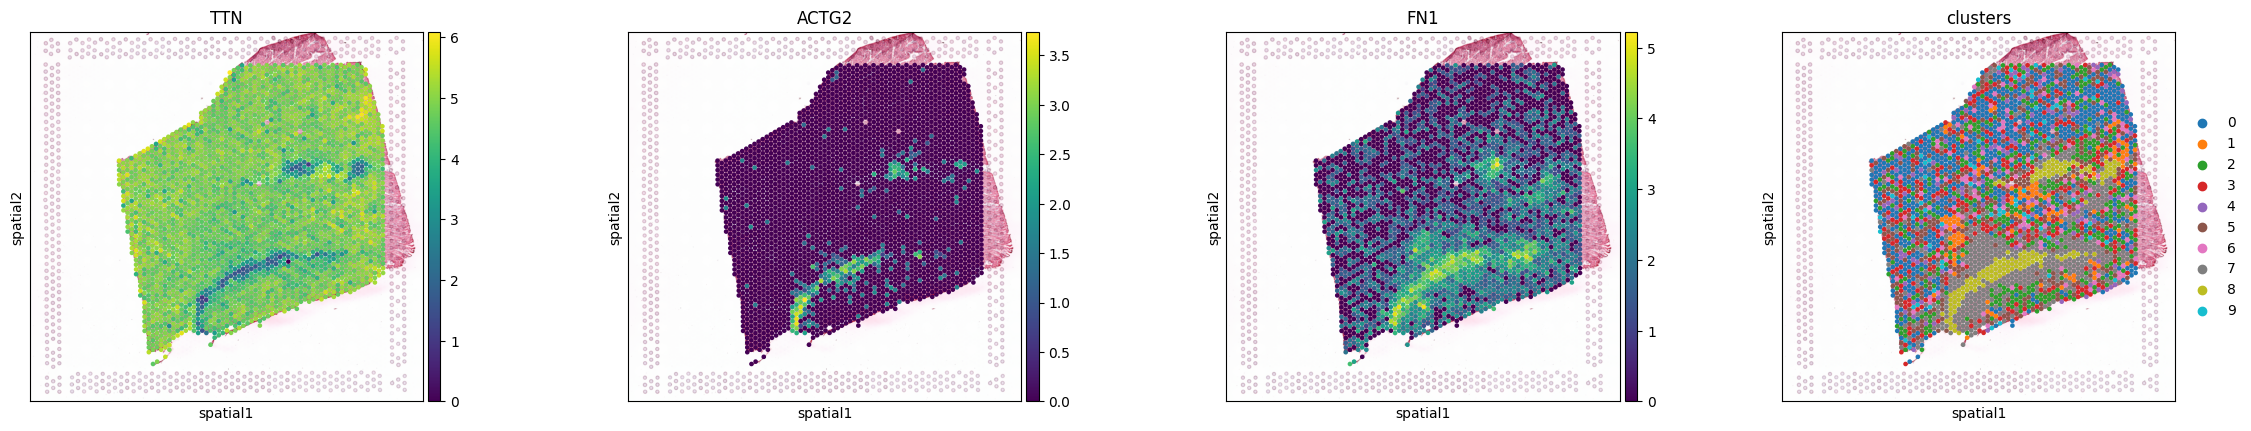

In [80]:
sq.pl.spatial_scatter(adata, color=["TTN", "ACTG2", "FN1", "clusters"], size=1.5)